# Predicting Housing Absorptions In The City of Toronto

Housing absorption is the rate at which homes in a particular market and timeframe are sold. It is an important metric that can be used for assessing a housing markets supply and demand levels.

For this project, I wanted to see whether I can build a regression model that accurately predicts, and then forecasts, the number of monthly housing absorptions in the City of Toronto. To keep it simple, I want to try and predict the total number of absorptions across all dwelling types (single, semi-detached, row, and apartment). However, it is very well possible to predict the number of absorptions by dwelling type, or even of another city, if one wanted to.

The idea for this project came to me when I was thinking about assessing the real estate market share in Toronto, and how a company can set absorption targets so that they achieve a desired market share. For example, let's say I was a realtor whose goal is to achieve a certain percent of the market sales. If I could accurately forecast the number of absorptions over a certain time period, I can then figure out how many sales I need to make in that time period to achieve my desired market share.

This is a time series forecasting type of prediction. I want to test out a couple ways in which the predictions can be made. First, I want to try a traditional machine learning regression approach which uses various economic data points (a multivariate model) to predict the number of absorptions. My thinking is that absorptions can be predicted by using a combination of economic data points like unemployment rate, borrowing rate, home prices, etc. After I will compare this approach to some traditional univariate time series forecasting methods. Lastly, I will finish off by assessing the very popular Facebook Prophet time series forecasting library to see how this compares to the other approaches.

The economic data for this notebook was gathered using the Statistics Canada (StatsCan) API. This API provides a connection to the StatsCan data portal, which contains thousands of economic datasets. Depending on the dataset, users of the portal can select data points that are specific to a geographic area. With the exception of a few features, most of the datapoints that I gathered for this notebook are specific to the Toronto metropolitan area. A link to the Statistics Canada data portal can be found here:

https://www150.statcan.gc.ca/n1//en/type/data?MM=1#tables

I should note that I did run into a snag trying to obtain absorption data for all dwelling types in Toronto using the StatsCan portal. The StatsCan portal only displays housing absorption figures for single and semi-detached units, rather than for all of the dwelling types. To get around this I downloaded a CSV file from the Canada Mortgage and Housing Corporation (CMHC) information portal that contains historical absorption data for all dwelling types in the City of Toronto. I made sure to validate what was in the StatsCan portal and the CMHC portal to ensure that the data did in fact match.

I know this is not the most practical solution to getting data from CMHC, as it is not scalable. The issue I faced here is that the CMHC portal is dynamic, meaning that I cannot easily scrape the data from it. In the future I would like to build a dynamic scrapper to retrieve data from CMHC without having to manually download it. A link to the CMHC portal can be found here:

https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart?id=2270&t=3

## Part 1 - The Multivariate Machine Learning Approach

In [1]:
#Import packages and set styling options

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import warnings
from stats_can import StatsCan
sc = StatsCan()

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('use_inf_as_na', True)
sns.set_style('whitegrid')

font = {'family':'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

## Loading In CMHC Data

Two data points were obtained from CMHC. The first is the dependent variable, total absorptions, while the second is the total number of newly built housing units that are unabsorbed at the time of completion. My assumption is that there is an inverse correlation between these two figures. I expect that if absorptions are high then the number of newly built units that go unabsorbed would be low.

In [2]:
absorptions = pd.read_csv('CMHC.csv', parse_dates=True, index_col= 'Date')
absorptions.head()

,Total_Absorptions,Inventory_of_Completed_and_Unabsorbed_All
Date,,
1990-01-01,2158,1634
1990-02-01,1992,1440
1990-03-01,2177,1621
1990-04-01,1690,2086
1990-05-01,2149,2088


In [3]:
absorptions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383 entries, 1990-01-01 to 2021-11-01
Data columns (total 2 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Total_Absorptions                          383 non-null    int64
 1   Inventory_of_Completed_and_Unabsorbed_All  383 non-null    int64
dtypes: int64(2)
memory usage: 9.0 KB


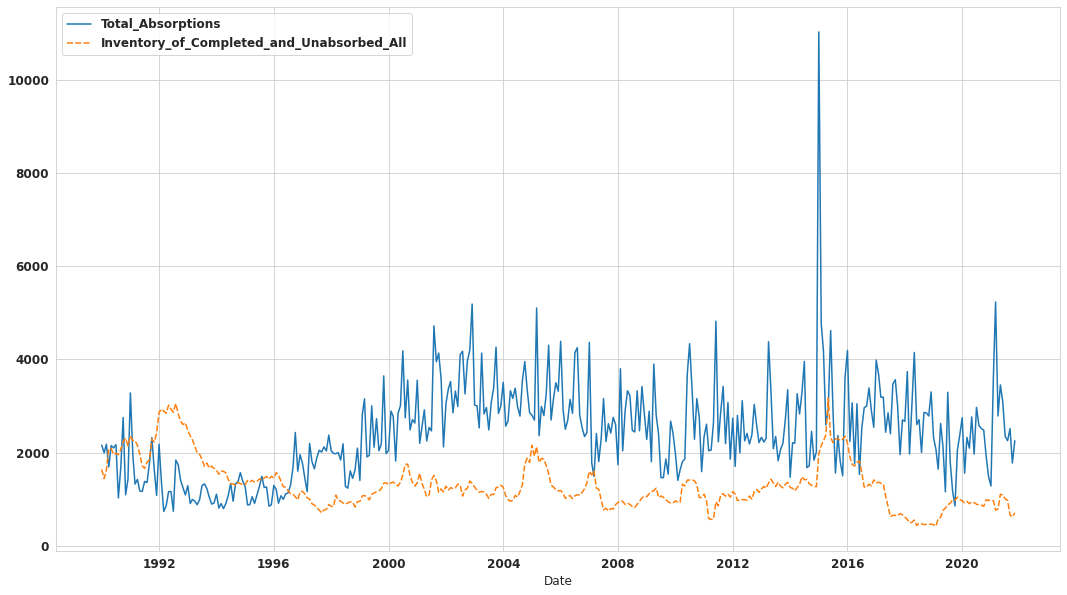

In [4]:
# Plot total absorptions

fig, ax = plt.subplots(figsize=[18,10])
sns.lineplot(data=absorptions);

I can see from this plot that the number of absorptions has been fairly range bound since the year 2000. There isn't a clear trend during this time either with several spikes, of which there is one large spike in 2015, making it look like the data is full of noise.

It also appears that there are points where the number of absorptions and the number of newly built units that go unabsorbed follow each other. However, there are also points where these figures look like they are the inverse of each other.

## Obtaining Economic Data From StatsCan

Since the absorption data is broken down by month, I decided that I am only going to use economic data points that had monthly frequencies. As previously mentioned, I used the StatsCan API to gather the economic data for this notebook. A link to the API documentation can be found in the link below:

https://stats-can.readthedocs.io/en/latest/

Using the StatsCan portal I was able to browse and find data points that I intuitively thought would make for good features in predicting housing absorptions. Each data point on the StatsCan portal displays a vector, when this vector is passed to the StatsCan API the data for that particular feature is returned.

Here is a list of the features that I obtained from StatsCan and the reasons why I chose them:

- The number of housing units created in the metropolitan Toronto area, for all dwelling types. In a competitive housing market, such as Toronto, there should be a strong correlation between housing completions and absorptions. The more units that are created, the more absorptions there should be. However, not all absorptions are from newly built units. Unfortunately, I couldn't find any readily available data points for the total number of available houses and active listings in the Toronto area.


- Toronto's population. Put simply, if Toronto's population is increasing then I expect that the number of absorptions should be increasing as well.


- Toronto's unemployment rate. I expect there to be a negative correlation with absorptions. As unemployment rises housing absorptions go down.


- The five-year term conventional mortgage rate. My original intention for mortgage data was to use a blend of fixed rate and variable rate mortgages. However, the StatsCan portal had more data points for the conventional mortgage rates than both the fixed and variable rates. Therefore, I opted for the conventional rate, which basically follows the fixed and variable rates anyway. I expect that this would have a negative correlation with absorptions. As the borrowing rate goes up fewer houses become absorbed.


- Toronto's inflation rate calculated by CPI year over year. While this metric is specific to Toronto, it essentially follows the national inflation rate. Central banks curb inflation by increasing borrowing rates, which in turn negatively impacts housing prices. There has been a lot of talk in Canada about rising inflation and the need to increase borrowing rates in the last few months. This interested me so I decided to add it as a feature in the model and see whether there is any material impact of inflation impacting housing absorptions.


- Toronto's year over year change in the new home price index. To me, it doesn't appear that price increases of a newly built homes in Toronto matters, there will always be a buyer no matter how drastic the prices have increased from previous points in time. I wanted to see if this was the case.


- The total construction investment into Toronto's residential buildings. I figured that if more money is being invested into residential construction then it is likely that homes are being absorbed at a faster rate.


- The total retail trade in dollars for Toronto. I like to think of this a barometer for economic health. Since one person's spending is another person's salary, I figured this would be positively correlated with absorptions.


- The year over year return on the Toronto Stock Exchange. While the stock exchange might not be a good indicator for the health of an economy, it is certainly a great vehicle to produce wealth. I expect that in periods of high returns there would be more absorptions. Conversely, I expect that in periods of low returns there would be fewer absorptions.


- The year over year M2 money supply. Despite being a national metric, this is a good indicator for assessing liquidity in an economy. I wanted to see if this measure has a material affect of housing absorptions.

In [5]:
#Create a dictionary of vector id's obtained from StatsCan portal

vec_map = {'Housing_Units_Created':'v42127485',
           'Population':'v1235049739', #x1000
           'Population_Archived':'v91446072',
           'Unemployment_Rate':'v1235049756',
           'Unemployment_Rate_Archived':'v91446080',
           'Conventional_Mortgage_Rate_Five_Year_Term':'v733833',
           'CPI_YoY':'v41692888',
           'New_Home_Price_Index_YoY':'v111955499',
           'Investment_In_Residential_Building_Construction':'v1014969726',
           'Retail_Trade_In_Dollars':'v114622303', #x1000
           'TSX_YoY':'v122620',
           'M2_YoY':'v41552796'
          }

#Convert the vectors id's to a list
vectors = list(vec_map.values())

#Pass the list to the StatsCan API which returns a pandas dataframe
statscan = sc.vectors_to_df(vectors)

#Rename the columns in the dataframe to match the dictionary
inv_map = {v: k for k, v in vec_map.items()}
statscan.columns = statscan.columns.to_series().map(inv_map)

#Set the index of the dataframe to the date column
statscan.index.names = ['Date']

statscan.head()

,Housing_Units_Created,Population,Population_Archived,Unemployment_Rate,Unemployment_Rate_Archived,Conventional_Mortgage_Rate_Five_Year_Term,CPI_YoY,New_Home_Price_Index_YoY,Investment_In_Residential_Building_Construction,Retail_Trade_In_Dollars,TSX_YoY,M2_YoY
Date,,,,,,,,,,,,
1951-01-01,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN
1951-02-01,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN
1951-03-01,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN
1951-04-01,NaN,NaN,NaN,NaN,NaN,5.25,NaN,NaN,NaN,NaN,NaN,NaN
1951-05-01,NaN,NaN,NaN,NaN,NaN,5.50,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Convert TSX, M2 and CPI to year over year percent change values

yoy_convert = ['TSX_YoY','M2_YoY','CPI_YoY','New_Home_Price_Index_YoY']

for i in yoy_convert:
    
    statscan[i] = statscan[i].pct_change(12)*100

statscan.tail()

,Housing_Units_Created,Population,Population_Archived,Unemployment_Rate,Unemployment_Rate_Archived,Conventional_Mortgage_Rate_Five_Year_Term,CPI_YoY,New_Home_Price_Index_YoY,Investment_In_Residential_Building_Construction,Retail_Trade_In_Dollars,TSX_YoY,M2_YoY
Date,,,,,,,,,,,,
2021-08-01,"2,433.00","5,577.10",NaN,9.00,NaN,3.20,3.28,7.45,"3,109,117,593.00","8,582,531.00",24.64,10.85
2021-09-01,"2,201.00","5,583.50",NaN,8.20,NaN,3.22,3.79,6.62,"2,970,093,152.00","8,210,342.00",24.49,9.83
2021-10-01,"1,949.00","5,591.10",NaN,7.90,NaN,3.29,4.05,7.35,"2,827,642,709.00","8,388,012.00",35.02,8.82
2021-11-01,"2,577.00","5,598.60",NaN,7.00,NaN,NaN,4.34,8.56,NaN,NaN,20.18,7.94
2021-12-01,NaN,"5,609.10",NaN,6.80,NaN,NaN,4.48,8.15,NaN,NaN,18.51,8.11


## Combining Archived Data - Population and Unemployment Rate

When I was going through the StatsCan portal I noticed that the datasets for population and unemployment rate had archived data that went back further than the most recent datasets. Therefore, I decided to fill the missing values in the most recent dataset with the values of the archived dataset.

In [7]:
#Fill the missing values of population and unemployment rate with archived data

statscan['Population'] = statscan['Population'].fillna(statscan['Population_Archived'])
statscan['Unemployment_Rate'] = statscan['Unemployment_Rate'].fillna(statscan['Unemployment_Rate_Archived'])

#Drop the archived data

statscan.drop(columns = ['Unemployment_Rate_Archived','Population_Archived'], inplace = True)

In [8]:
statscan.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 852 entries, 1951-01-01 to 2021-12-01
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Housing_Units_Created                            599 non-null    float64
 1   Population                                       250 non-null    float64
 2   Unemployment_Rate                                250 non-null    float64
 3   Conventional_Mortgage_Rate_Five_Year_Term        850 non-null    float64
 4   CPI_YoY                                          600 non-null    float64
 5   New_Home_Price_Index_YoY                         480 non-null    float64
 6   Investment_In_Residential_Building_Construction  142 non-null    float64
 7   Retail_Trade_In_Dollars                          214 non-null    float64
 8   TSX_YoY                                          780 non-null    float64
 9   M2_YoY       

## Joining The Datasets Together

In [9]:
combined = pd.merge(absorptions, statscan, on= 'Date', how = 'left')
combined.head()

,Total_Absorptions,Inventory_of_Completed_and_Unabsorbed_All,Housing_Units_Created,Population,Unemployment_Rate,Conventional_Mortgage_Rate_Five_Year_Term,CPI_YoY,New_Home_Price_Index_YoY,Investment_In_Residential_Building_Construction,Retail_Trade_In_Dollars,TSX_YoY,M2_YoY
Date,,,,,,,,,,,,
1990-01-01,2158,1634,"2,965.00",NaN,NaN,12.01,5.88,8.56,NaN,NaN,2.43,14.16
1990-02-01,1992,1440,"2,148.00",NaN,NaN,12.42,5.98,4.37,NaN,NaN,3.21,14.62
1990-03-01,2177,1621,"3,146.00",NaN,NaN,12.92,5.53,1.37,NaN,NaN,1.72,13.88
1990-04-01,1690,2086,"3,031.00",NaN,NaN,13.67,4.97,-0.60,NaN,NaN,-7.91,13.12
1990-05-01,2149,2088,"2,581.00",NaN,NaN,14.21,4.53,-1.05,NaN,NaN,-3.38,12.57


## Checking Missing Values

In [10]:
#Create a series that calculates the number of missing values and percent of missing values per column

total_missing = combined.isnull().sum().sort_values(ascending=False)
percent = (combined.isnull().sum()/combined.isnull().count()).sort_values(ascending=False) * 100

#Pass the series into a pandas dataframe

missing_data = pd.concat([total_missing, percent], axis=1, keys=['Total Missing', 'Percent Missing'])
missing_data.head()

,Total Missing,Percent Missing
Investment_In_Residential_Building_Construction,241,62.92
Retail_Trade_In_Dollars,169,44.13
Population,134,34.99
Unemployment_Rate,134,34.99
Conventional_Mortgage_Rate_Five_Year_Term,1,0.26


Admittedly, I wasn't expecting to have such a large number of missing values when I first started working on this project. It turns out that some of the data on the StatsCan portal didn't go as far back I was hoping for. While the CMHC data goes back to 1990, some of the features from StatsCan only go as far back as 2001 (population and unemployment rate).

I spent a lot of time tackling this problem and trying to come up with reasonable solutions for dealing with the missing values. One approach I took was imputing missing values using scikit-learns intuitive imputer built on a Random Forest regressor. This is a multivariate type of imputing which uses all the features, and their relationships with each other, to determine the missing values. The problem with this approach was that it didn't yield realistic results. For example, unemployment rate went negative using this approach, which isn't possible. It also led to a large amount of multicollinearity as features would start mirroring each other.

In the end, I determined that it would be best to remove investment in residential building construction and retail trade while keeping population and unemployment rate, but remove the values where there was missing data. The reason for this is simply that too many values for investment in residential building construction and retail trade were missing. While this approach eliminated 35% of my original data, it still left me with twenty years of absorption data to model, which I thought was reasonable.

In [11]:
columns_to_drop = ['Investment_In_Residential_Building_Construction','Retail_Trade_In_Dollars']

combined.drop(columns=columns_to_drop, inplace = True)

In [12]:
#Drop missing values

df = combined.dropna()

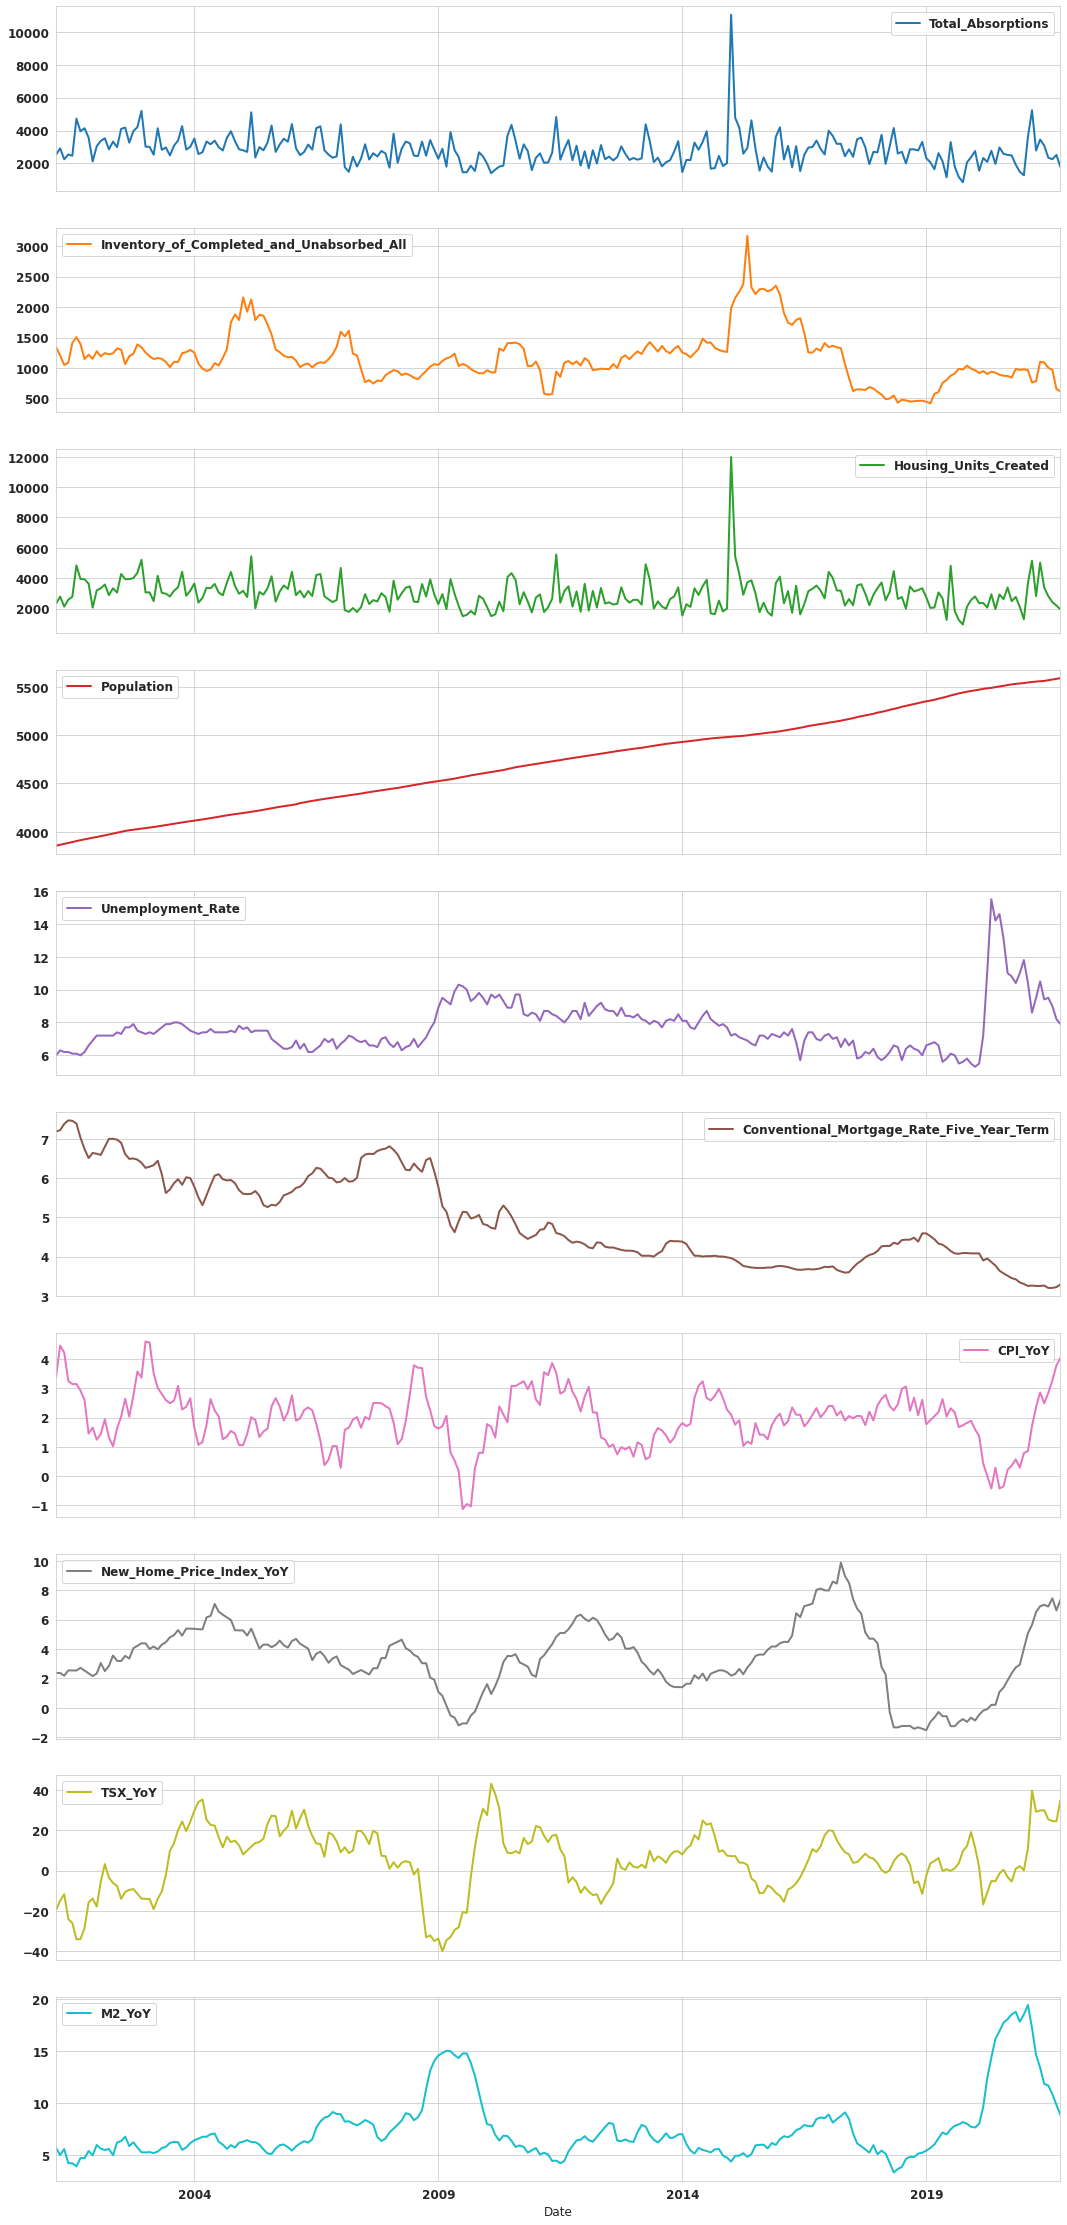

In [13]:
#Plot the data after droping columns

fig, ax = plt.subplots(figsize=(18, 40))
df.plot(ax=ax, subplots= True, sharex = True, lw = 2);

A few things stand out to me from the plot above:

- Absorptions appear to be stationary (consistent mean and standard deviation) and the data is in fact noisy with no apparent seasonal pattern.


- Absorptions and the number of housing units created are very closely tied to each other. Their plots are almost identical. The large spike in absorptions can be explained by the large spike of housing units created.


- The effects of the 2008 financial fallout and the more recent COVID pandemic are very apparent, as seen through unemployment rate, CPI, new home prices, TSX returns, and M2.


- Toronto's population has been increasing steadily while the conventional mortgage rate has been falling steadily.

To get a better sense of the trend and seasonality in total absorptions I will plot both of these using the statsmodel STL package.

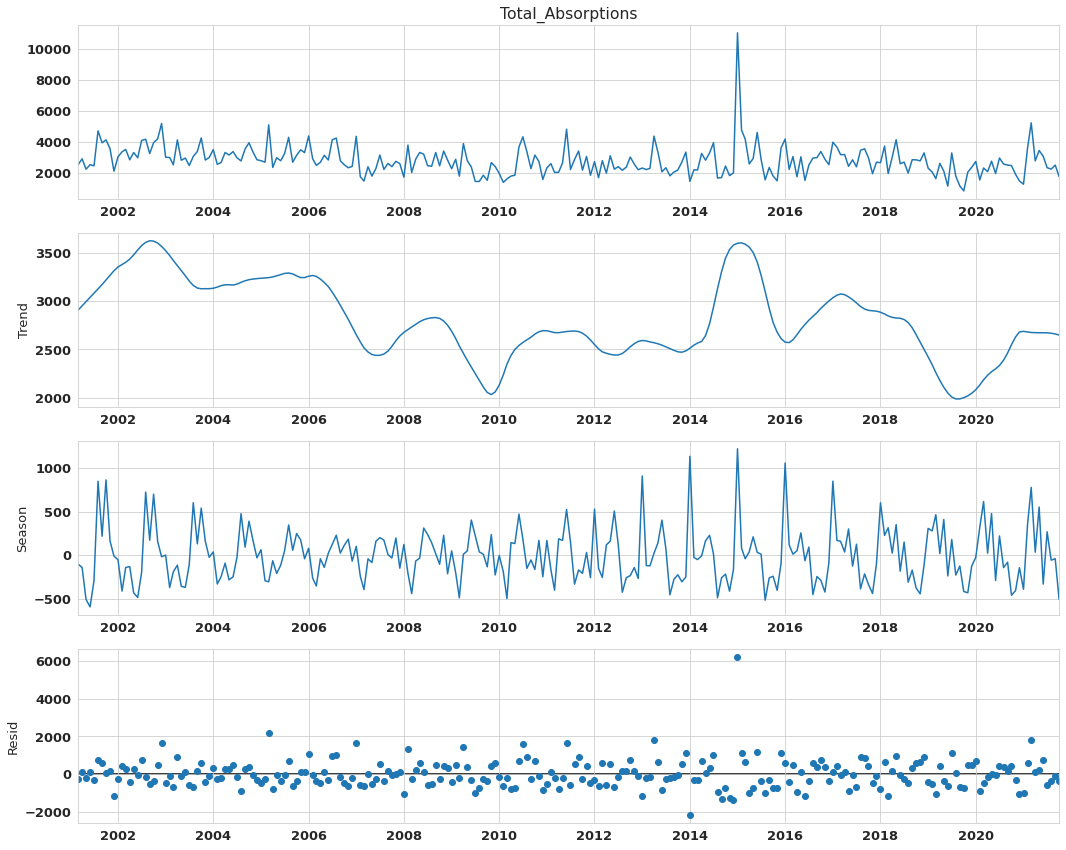

In [14]:
from statsmodels.tsa.seasonal import STL
plt.rc("figure", figsize=(15, 12))
plt.rc("font", size=13)
stl = STL(df.Total_Absorptions, seasonal=13) #Seasonal has to be set to an odd value. 13 captures yearly seasonality
res = stl.fit()
fig = res.plot()

From this plot I can see that there is no consistent trend in total absorptions, it seems to fluctuate randomly. Seasonality doesn't appear to be consistent either, which leads me to believe that the STL package is picking up noise in the data. Lastly, if trend and seasonality are removed, the residuals still show signs of deviation.

All of this suggests that it might be too complicated to accurately predict, and forecast, what the total absorptions will be. Nevertheless, I would still like to see how the various models hold up and determine which one should be used in forecasting.

## Handling Skewed Features With Log Transformation

Before going into further exploratory data analysis I decided that it would be best to assess, and subsequently fix, the skewness of the features.

In [15]:
#Assess the skew of each feature

skew_features = df.apply(lambda x: skew(x)).sort_values(ascending=False)
skew_features

Housing_Units_Created                        2.92
Total_Absorptions                            2.72
M2_YoY                                       1.94
Unemployment_Rate                            1.78
Inventory_of_Completed_and_Unabsorbed_All    1.19
Conventional_Mortgage_Rate_Five_Year_Term    0.42
Population                                   0.03
New_Home_Price_Index_YoY                    -0.10
CPI_YoY                                     -0.25
TSX_YoY                                     -0.40
dtype: float64

Since most of the data is positive (right) skewed, I will log transform the heavily skewed features. This will be the features with a skew greater than 0.5.

In [16]:
#Log transform each feature that is greater than 0.5 skew 

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    
    df[i] = np.log(df[i])

df.skew().sort_values(ascending=False)

M2_YoY                                       1.09
Unemployment_Rate                            0.90
Conventional_Mortgage_Rate_Five_Year_Term    0.42
Housing_Units_Created                        0.07
Population                                   0.03
Total_Absorptions                           -0.03
New_Home_Price_Index_YoY                    -0.10
CPI_YoY                                     -0.25
Inventory_of_Completed_and_Unabsorbed_All   -0.27
TSX_YoY                                     -0.40
dtype: float64

## Checking The Distributions

After converting the skewed features to log values I decided to look at the distribution of each feature, as well as the relationship that each feature has with absorptions, via a scatter plot.

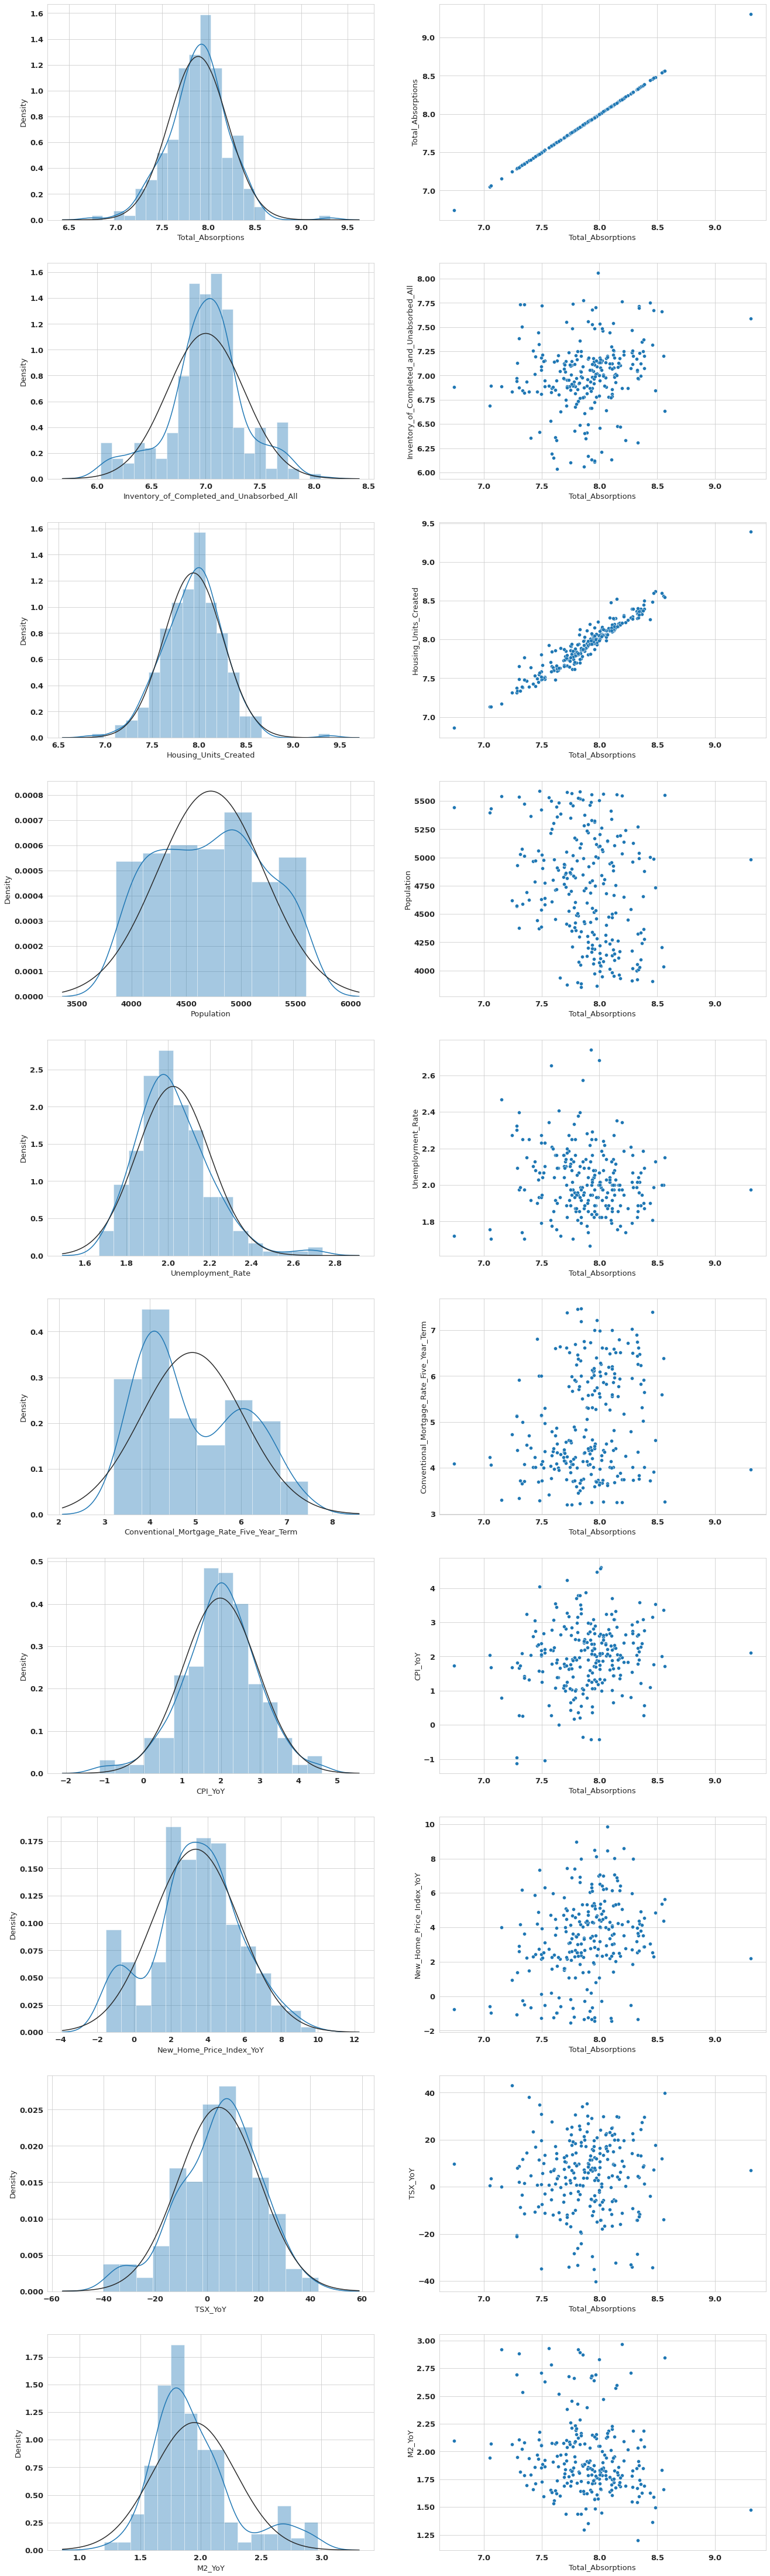

In [17]:
# Create columns for plotting and further EDA

cols = ['Total_Absorptions','Inventory_of_Completed_and_Unabsorbed_All', 'Housing_Units_Created', 'Population',
       'Unemployment_Rate', 'Conventional_Mortgage_Rate_Five_Year_Term',
       'CPI_YoY', 'New_Home_Price_Index_YoY', 'TSX_YoY','M2_YoY']

#Plot histogram and scatter plots for each column

a = len(cols)  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(22,80))

for i in cols:
    plt.subplot(a, b, c)
    sns.distplot(df[i], fit=norm)
    c = c + 1
    
    plt.subplot(a, b, c)
    plt.xlabel('Total_Absorptions')
    sns.scatterplot(data = df, x = 'Total_Absorptions', y = df[i])
    c = c + 1

plt.show()

Most of the features appear close to normally distributed after their log transformations. As previously observed, total absorptions and housing units created have a very strong linear relationship with each other. 

When looking across the scatterplots it appears that there is an outlier on all of the plots. This outlier is the large spike in absorptions that occurred in the month of January 2015 when over 11,000 housing units were absorbed in just one month. This outlier can be explained by the large number of housing units that were created for that month. Since this outlier is explained by the number of housing completions, and is not an error, I am going to opt for leaving it in the data frame.

With the exception of housing units created, none of the other features appear to have linear relationships with total absorptions.

## Creating Lag Features

In order to turn a time series problem into a supervised machine learning problem I will have to lag all of the features and subsequently create another feature which is the lag value of total absorptions itself. This is because time series problems are based on the premise that future values can be predicted using data from previous points in time. To find out how many periods I need to lag my features by I will use the autocorrelation and partial autocorrelation plots.

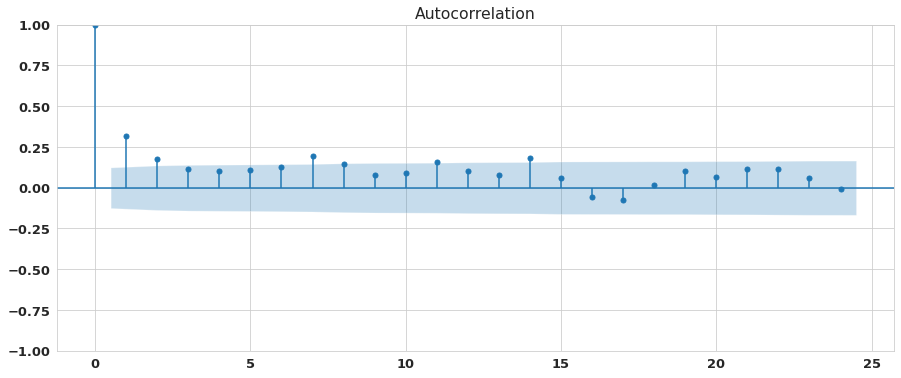

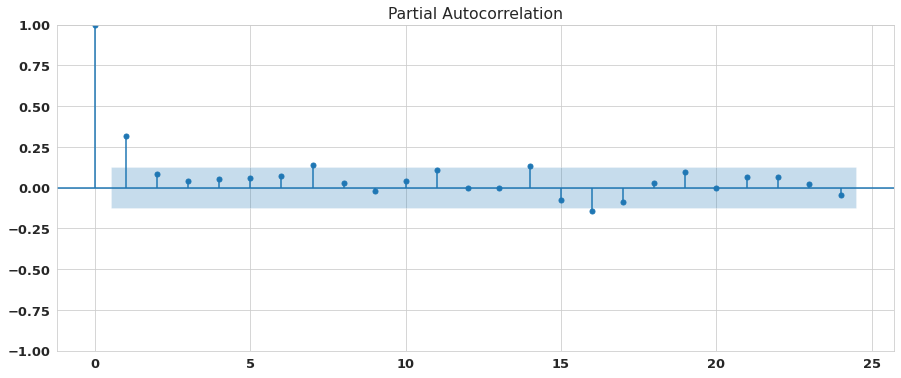

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rc("figure", figsize=(15, 6))
plot_acf(df.Total_Absorptions)
plt.show();
plot_pacf(df.Total_Absorptions)
plt.show();

From these two plots it appears that a period of one lag is statistically significant. I can also see that there is a drastic decrease to near zero for the other lag values, which implies that total absorptions is stationary. I will also note that neither of these plots show a statistically significant correlation at lag 12, which suggests that yearly seasonality is not present.

Since one lag is statistically significant, I will use now shift all my features by a period of one month.

In [19]:
# Create a lag of total absorptions

df['Total_Absorptions_Lag1'] = df.Total_Absorptions.shift(1)

#Lag all of the other features by 1 month

cols_to_lag = ['Inventory_of_Completed_and_Unabsorbed_All','Housing_Units_Created','Population','Unemployment_Rate','Conventional_Mortgage_Rate_Five_Year_Term',
              'CPI_YoY','New_Home_Price_Index_YoY','TSX_YoY','M2_YoY']

for i in cols_to_lag:
    
    df[i] = df[i].shift(1)

# Drop null values from the dataframe

df.dropna(inplace= True)

In [20]:
#Rename the columns to distinguish that the features are now lagged

new_columns = {'Inventory_of_Completed_and_Unabsorbed_All':'Inventory_of_Completed_and_Unabsorbed_All_Lag1',
               'Housing_Units_Created':'Housing_Units_Created_Lag1',
               'Population':'Population_Lag1',
              'Unemployment_Rate':'Unemployment_Rate_Lag1',
              'Conventional_Mortgage_Rate_Five_Year_Term':'Conventional_Mortgage_Rate_Five_Year_Term_Lag1',
               'CPI_YoY':'CPI_YoY_Lag1',
              'New_Home_Price_Index_YoY':'New_Home_Price_Index_YoY_Lag1',
              'TSX_YoY':'TSX_YoY_Lag1',
              'M2_YoY':'M2_YoY_Lag1'}

df.rename(columns = new_columns, inplace = True)

## Checking Correlations

Now I would like to create a heatmap to see how correlated the lag features are to total absorptions.

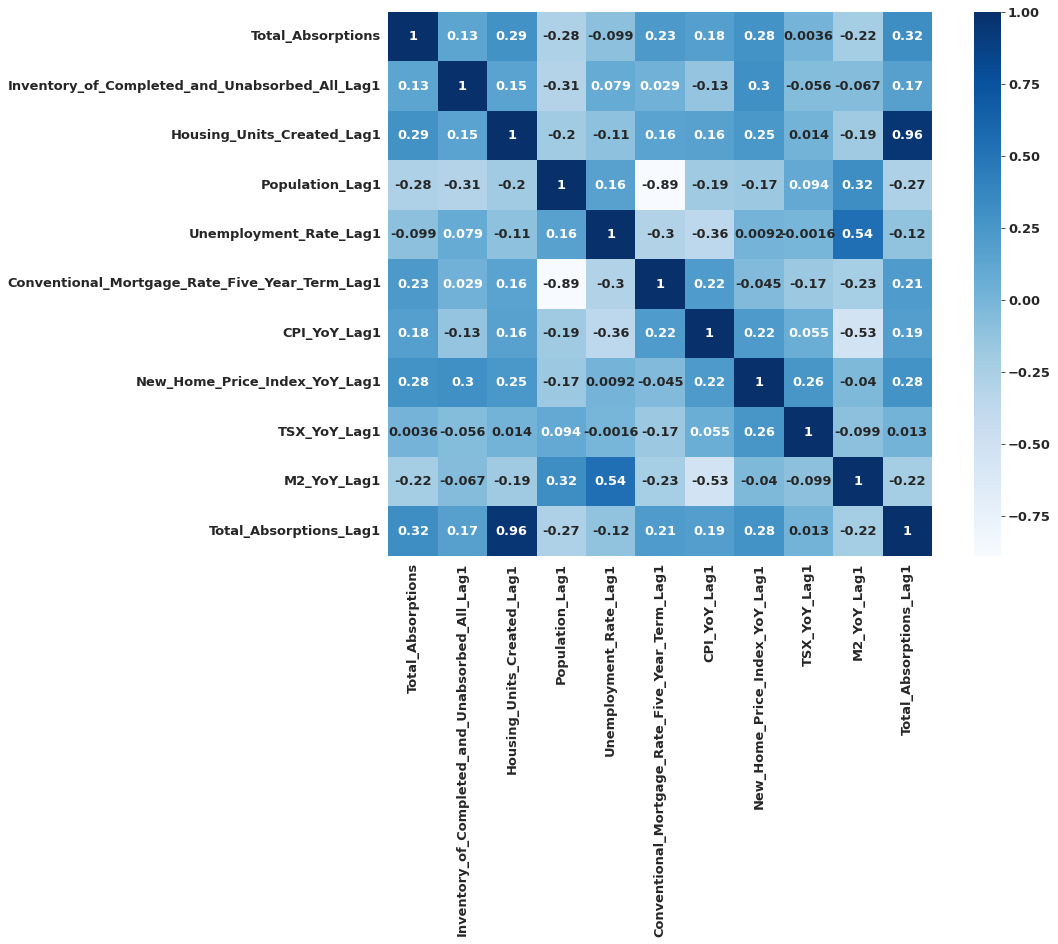

In [21]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, square=True, cmap = 'Blues', annot = True);

None of the lagged features appear to have a strong correlation with total absorptions.

The strong linear relationship between total absorptions at lag 1 and housing units created at lag 1 is very apparent on the heatmap, which shows a high 0.96 Pearson correlation between these features. Since these two features are essentially the same, I am going to opt for removing housing units created at lag 1, which will reduce multicollinearity.

I can see that there are a couple of other features that appear to have strong correlations, such as population and mortgage rate, as well as unemployment rate and M2. For now, I am going to leave all of these features in place. The reason for this is that I plan to test out a couple of regularization models such as Lasso, Ridge, and ElasticNet which account for multicollinearity by reducing the magnitude of the coefficients. Additionally, I don't want to remove too many features since there could be a combination effect where multiple features have a combined impact on the dependant variable.

In [22]:
#Remove the housing units created lag

df.drop('Housing_Units_Created_Lag1', axis=1, inplace=True)

## Testing Models And Hyperparameter Tuning With Pipeline

For the model building, I want to see how regularized and ensemble methods compare to each other. To do this I will set up a pipeline dictionary containing all of the models, along with a hyperparameter dictionary for the respective models. I will then pass both of these dictionaries through GridSearchCV which will provide me with the best performing hyperparameters for each model. I will then be able to compare all of the models to each other.

For assessing model performance, I will use mean absolute error, root mean squared error, and mean absolute percentage error with five-fold cross validation.

In [23]:
#Establish x and y variables

y = df.Total_Absorptions
X = df.drop(['Total_Absorptions'], axis =1)

Since this is a time series problem, I cannot split the data randomly using train test split. This is because the observations in time series data is assumed to be dependent on data from previous points in time, in this case it is the previous month. Splitting the data randomly would cause data leakage and yield unrealistic results. Therefore I am going to split the data so that the last two years is my test set.

In [24]:
#Split X and y into train and test sets.

test_obs = 24 #Two years

X_train = X[:-test_obs]
X_test = X[-test_obs:]
y_train = y[:-test_obs]
y_test = y[-test_obs:]

In [25]:
#Scale the x values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) #Because the scaler has already been fit on X_train you only need to use transform on X_test

In [26]:
#Import various models and performance metrics

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [103]:
#Function for evaluating model performance

def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mape = mean_absolute_percentage_error(true, predicted)*100
    print('Mean Absolute Error:', np.round(mae))
    print('Root Mean Sqaured Error:', np.round(rmse))
    print('Mean Absolute Percent Error', np.round(mape))
    print('__________________________________')

#Function for plotting the results

def plot_results(dataframe,title): 
    fig, ax = plt.subplots(figsize=[16,8])
    ax = sns.lineplot(data=dataframe, markers = True)
    ax.set_title('Predicting Housing Absorptions In Toronto Using ' + title)
    ax.set_ylabel('Number of Monthly Housing Absorptions');

In [28]:
#Create a pipeline for each model that is going to be tested.

pipelines = {
    'Ridge': make_pipeline(Ridge(random_state=1)),
    'Lasso': make_pipeline(Lasso(random_state=1)),
    'ElasticNet' :  make_pipeline(ElasticNet(random_state=1)),
    'RandomForest': make_pipeline(RandomForestRegressor(random_state=1)),    
    'GradientBoost': make_pipeline(GradientBoostingRegressor(random_state=1)),
    'XGBoost': make_pipeline(XGBRegressor(random_state=1))
}

In [29]:
#Establish all the hyperparameters in a dictionary that are going to be tested on the training sets

hyperparameters = {

'Ridge' : {
     'ridge__alpha' : [0.005, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10]
    },
    
'Lasso' : {
     'lasso__alpha' : [0.005, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10]
    },

'ElasticNet' : { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10], 
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
    },

'RandomForest' : {
     'randomforestregressor__n_estimators' : [50, 100, 150, 200, 300],
     'randomforestregressor__min_samples_leaf' : [1, 3, 5],
     'randomforestregressor__max_depth' : [3, 5, 10, 15],    
    },

'GradientBoost' : {
    'gradientboostingregressor__n_estimators' : [50, 100, 150, 200, 300],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.15, 0.3],
    'gradientboostingregressor__max_depth' : [3, 6, 10, 15]
    },

'XGBoost' : {
    'xgbregressor__n_estimators' : [50, 100, 150, 200, 300],
    'xgbregressor__learning_rate' : [0.05, 0.1, 0.15, 0.3],
    'xgbregressor__max_depth' : [3, 5, 10, 15],
    }
    
}

In [30]:
fitted_models = {} #Establishes a dictionary that will hold the model and its best performing hyperparameters

# Grid search each model and hyperparameter with 5 fold cross validation

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, 
                         hyperparameters[name], 
                         cv=5,
                         return_train_score = False)
    model.fit(X_train, y_train)
    fitted_models[name] = model

In [31]:
# Calculate MAE, RMSE and MAPE by passing X_test and y_test to each model. Print out the best performing parameters using the best_params_ command
# Using the np.exp will convert the log values back to their original scale

for name, model in fitted_models.items():
   pred = model.predict(X_test)
   print(name)
   print(' — — — — ')
   print('Mean Absolute Error:', mean_absolute_error(np.exp(y_test), np.exp(pred)))
   print('Root Mean Squared Error:', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred))))
   print('Mean Absolute Percent Error:', mean_absolute_percentage_error(np.exp(y_test), np.exp(pred))*100)
   print() 
   print('This models best performing parameters are ' + str(model.best_params_))
   print()

Ridge
 — — — — 
Mean Absolute Error: 702.7253498431564
Root Mean Squared Error: 987.3238317928827
Mean Absolute Percent Error: 24.82719653442597

This models best performing parameters are {'ridge__alpha': 10}

Lasso
 — — — — 
Mean Absolute Error: 639.5770980267403
Root Mean Squared Error: 926.1621308299734
Mean Absolute Percent Error: 22.868742217845817

This models best performing parameters are {'lasso__alpha': 0.01}

ElasticNet
 — — — — 
Mean Absolute Error: 666.1468815621929
Root Mean Squared Error: 953.5308228884736
Mean Absolute Percent Error: 23.67367333724645

This models best performing parameters are {'elasticnet__alpha': 0.05, 'elasticnet__l1_ratio': 0.1}

RandomForest
 — — — — 
Mean Absolute Error: 648.973666885554
Root Mean Squared Error: 889.2455334472137
Mean Absolute Percent Error: 24.233106805799583

This models best performing parameters are {'randomforestregressor__max_depth': 3, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__n_estimators': 10

After passing each model, and the respective hyperparameters, through GridSearchCV it appears that Lasso has delivered the best performing results. The exception is Random Forest which edged Lasso in root mean squared error. I will note that a 0.01 Lasso alpha is a rather low and not that far off from what a linear regression model would produce.

## Making Predictions Using Lasso

Now that I know a Lasso regression yields the best performing results I will create a separate instance of this algorithm with an alpha value of 0.01 and visualize the predictions.

In [32]:
regr = Lasso(alpha = 0.01)
regr.fit(X_train, y_train)

#Convert the log values back to original scale using np.exp
preds = np.round(np.exp(regr.predict(X_test)))
y_test = np.exp(y_test)

#Output the actual absorptions and predictions in a dataframe
results = pd.DataFrame({'Actual_Absorptions': y_test, 'Lasso_Predicted_Absorptions': preds})
results

,Actual_Absorptions,Lasso_Predicted_Absorptions
Date,,
2019-11-01,"2,057.00","1,775.00"
2019-12-01,"2,372.00","2,019.00"
2020-01-01,"2,749.00","2,085.00"
2020-02-01,"1,556.00","2,132.00"
2020-03-01,"2,325.00","1,972.00"
2020-04-01,"2,093.00","2,045.00"
2020-05-01,"2,766.00","1,911.00"
2020-06-01,"1,967.00","1,938.00"
2020-07-01,"2,971.00","1,794.00"


Mean Absolute Error: 640.0
Root Mean Sqaured Error: 926.0
Mean Absolute Percent Error 23.0
__________________________________


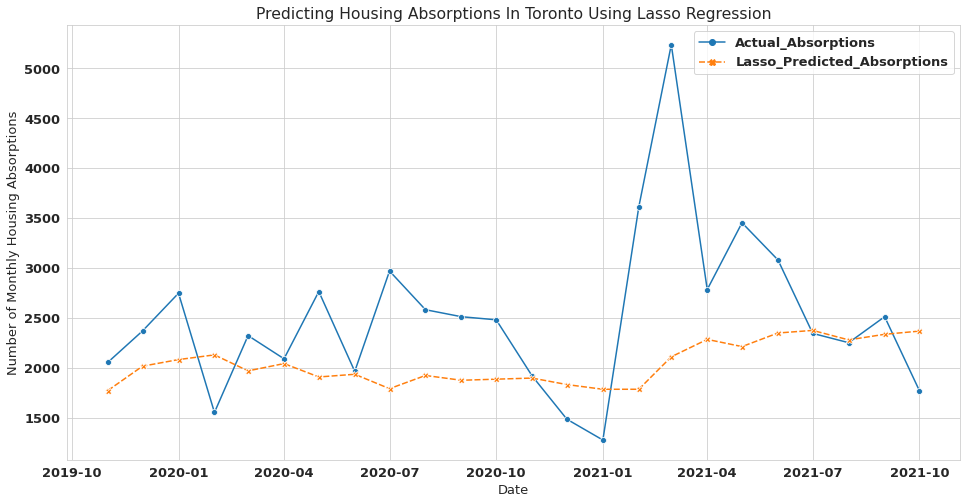

In [104]:
#Plot the results

plot_results(results,'Lasso Regression')

#Double check that the model performance is the same results as the grid search

print_evaluate(results.Actual_Absorptions, results.Lasso_Predicted_Absorptions)

It appears that the Lasso model generally follows the trend of absorptions, but typically under predicts what the actual absorptions are. To me, it appears that the model closely resembles that of a large moving average period. I will test out whether this is in fact the case in the univariate section.

Since my original assumption for this project was that housing absorptions can be predicted using various economic features, I would like to see exactly what economic features went into making this prediction. Fortunately, the Lasso algorithm does feature selection behind the scenes and will eliminate features that do not have a material impact on the dependant variable. I can visualize this by plotting the coefficients of the model to see what features are eliminated, and what features are being used to predict the dependent variable.

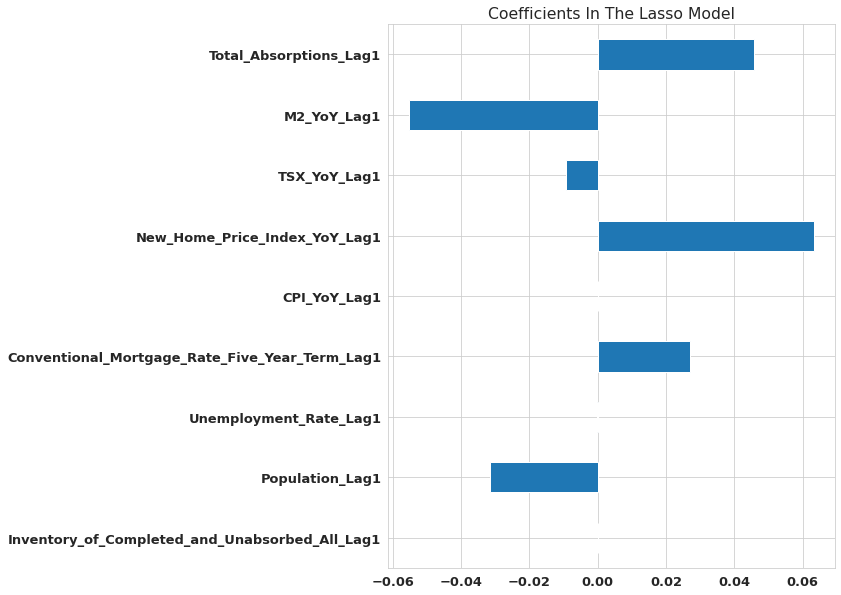

In [34]:
#Check which features Lasso uses to make predictions

coef = pd.Series(regr.coef_, index = X.columns)
plt.rcParams['figure.figsize'] = (8.0, 10.0)
coef.plot(kind = "barh")
plt.title("Coefficients In The Lasso Model");

It appears that the year over year CPI rate (inflation), unemployment rate, and inventory of completed and unabsorbed housing units have been eliminated. Interestingly, the year over year new home price index has the largest coefficient that contributes to the prediction of housing absorptions. This make sense, as the trend line in the STL plot closely follows the trend in the year over year increase in the new home price index.

This concludes the first part of the project. While the Lasso model performed decently, there are limitation to this approach. Firstly, it is fairly complicated and does not easily allow for forecasting into periods beyond the data frame. Secondly, it is limited by depending on StatsCan to update the economic data. Sometimes it can take a while for the latest economic data to become available. Based on the way the model is set up, I can only forecast one month ahead, and only if I have data for all of the features. Therefore, by the time the data does become available the forecasts might already be outdated.

This is where the univariate approaches come in handy, since you only need the dependant variable to make predictions.

## Part 2 - The Univariate Approach (Traditional Methods)

There are a couple of univariate models that I would like to compare to the Lasso model. Since it appears that the Lasso predictions follow the mean value of total absorptions, I will start by looking at a three-month rolling mean, and then progress into a twelve-month rolling mean.

Additionally, since I observed that the total absorptions is stationary, I will also test out an autoregressive moving average approach (ARMA).

In [35]:
#Make a copy of absorptions and convert back to original scale

df_uni = np.exp(df.Total_Absorptions).copy()
df_uni.head()

Date
2001-04-01   2,918.00
2001-05-01   2,249.00
2001-06-01   2,540.00
2001-07-01   2,465.00
2001-08-01   4,723.00
Name: Total_Absorptions, dtype: float64

## Simple Three Month Moving Average Approach

Mean Absolute Error: 713.0
Root Mean Sqaured Error: 969.0
Mean Absolute Percent Error 28.0
__________________________________


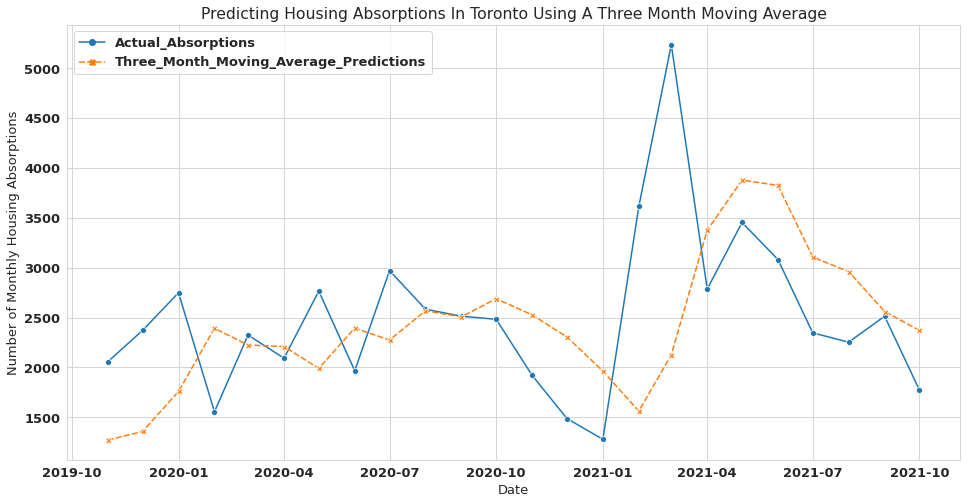

In [105]:
sma_3 = pd.DataFrame({'Actual_Absorptions': df_uni, 'Three_Month_Moving_Average_Predictions': df_uni.rolling(3).mean().shift(1)})
sma_3 = sma_3.dropna()
sma_3 = sma_3.tail(test_obs)

#Plot the results

plot_results(sma_3,'A Three Month Moving Average')

#Print the prediction performance results

print_evaluate(sma_3.Actual_Absorptions, sma_3.Three_Month_Moving_Average_Predictions)

While the three-month moving average approach is a lot more responsive to the fluctuations in total absorptions, it doesn't appear to perform better than the Lasso model. Let's see how a twelve-month moving average prediction model turns out.

## Simple Twelve Month Moving Average Approach

Mean Absolute Error: 630.0
Root Mean Sqaured Error: 859.0
Mean Absolute Percent Error 25.0
__________________________________


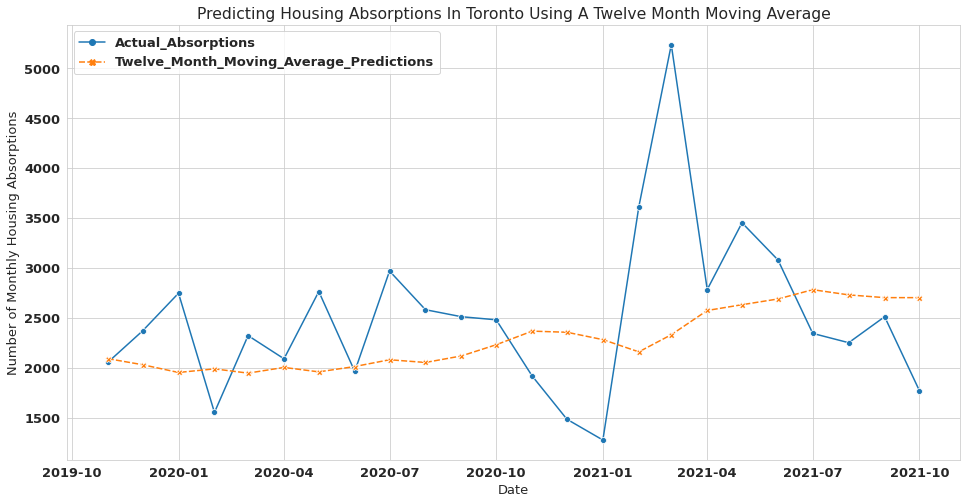

In [106]:
sma_12 = pd.DataFrame({'Actual_Absorptions': df_uni, 'Twelve_Month_Moving_Average_Predictions': df_uni.rolling(12).mean().shift(1)})
sma_12 = sma_12.dropna()
sma_12 = sma_12.tail(test_obs)

#Plot the results

plot_results(sma_12,'A Twelve Month Moving Average')

#Print the prediction performance results

print_evaluate(sma_12.Actual_Absorptions, sma_12.Twelve_Month_Moving_Average_Predictions)

The twelve-month moving average approach actually performs better than the Lasso model on a mean absolute error, and root mean squared error basis. The predictions appear very similar to the Lasso model too, in that they follow the overall trend. Based on this, I would rule out the use of the Lasso model for making predictions. It is far more complicated to develop, understand, and does not easily allow for forecasting into periods beyond the data frame. Rather than trying to build out a complicated approach for predicting absorptions, you would probably be better off if you just stick to a simple solution. However, the twelve-month moving average approach is limited. It only allows for forecasting one month ahead in time, which may not be very practical. This is where the ARMA model comes in handy. Given its recursive design, it allows for forecasting multiple periods outside of the data frame.

## Autoregressive Moving Average (ARMA) Approach

The reason for using an ARMA model over an ARIMA model is that absorptions is already a stationary dataset, as seen in the ACF and PACF plots. No differencing is required. To be safe I will apply a Dickey-Fuller test that checks whether a series of data is stationary or not.

In [38]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs

In [39]:
def test_stationarity(timeseries):
      
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])

#check to see if the time-series is stationary or non-stationary

test_stationarity(df_uni)

Results of Dickey-Fuller Test:
p-value= 3.1613852415134963e-22


In [40]:
#Double check that no differincing is required

ndiffs(df_uni, test='adf') 

0

Since the Dickey-Fuller test resulted in an very small p-value, it is highly unlikely that total absorptions is not stationary. Therefore, I can proceed with an ARMA model.

In [41]:
#Train test split for new univariate variable

X_uni = df_uni
trainset, testset= X_uni[:-test_obs:], X_uni[-test_obs:]

#Set prediction start and end dates
pred_start_date = testset.index[0]
pred_end_date = testset.index[-1]

## ARMA (1,7)

The PACF plot from above showed that a period of one would make for an appropriate autoregressive (p) component in the ARMA model. There are a couple of moving average values that showed to be significant in the ACF plot. Based on what I have seen in the simple moving average section, the larger moving average window appears to be a better predictor. Therefore, I am going to use seven for the moving average (q) component, as it is largest value within a reasonable timeframe that is statistically significant.

I will first start by assessing the summary statistics for an ARMA (1,7) model.

In [42]:
ARMA_model_test_one = ARIMA(trainset, order=(1,0,7)).fit()
print(ARMA_model_test_one.summary())

C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:      Total_Absorptions   No. Observations:                  223
Model:                 ARIMA(1, 0, 7)   Log Likelihood               -1843.062
Date:                Thu, 20 Jan 2022   AIC                           3706.124
Time:                        10:37:52   BIC                           3740.195
Sample:                    04-01-2001   HQIC                          3719.878
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2844.5394    173.606     16.385      0.000    2504.277    3184.801
ar.L1          0.8110      0.244      3.328      0.001       0.333       1.289
ma.L1         -0.5965      0.275     -2.166      0.0

The summary statistics show that a lot of the coefficients are statistically insignificant. I can also see that the Ljung-Box statistic is 0, which implies that the model errors are autocorrelated. Overall, this shows a lack of fit and that the predictions cannot be trusted. To remedy this I will try another instance of the ARMA (1,7) model but eliminate all of the coefficients that are statistically insignificant while keeping the q component at 7.

In [43]:
ARMA_model_test_two = ARIMA(trainset, order=(1,0,[7])).fit()
print(ARMA_model_test_two.summary())

                               SARIMAX Results                                
Dep. Variable:      Total_Absorptions   No. Observations:                  223
Model:               ARIMA(1, 0, [7])   Log Likelihood               -1845.020
Date:                Thu, 20 Jan 2022   AIC                           3698.040
Time:                        10:37:52   BIC                           3711.669
Sample:                    04-01-2001   HQIC                          3703.542
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2844.5426    114.373     24.871      0.000    2620.376    3068.709
ar.L1          0.2320      0.097      2.399      0.016       0.042       0.422
ma.L7          0.0682      0.053      1.293      0.1

C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


This approach hasn't faired much better. The moving average at lag seven is still statistically insignificant and the Ljung-Box statistic has only increased marginally. All of these factors combined suggest that predicting absorptions using an ARMA (1,7) model is more than likely moot.

## ARMA (7,7)

The PACF plot did however show a statistically significant p component at lag 7. I will use this in another instance of the ARMA model while keeping q at 7.

In [44]:
ARMA_model_test_three = ARIMA(trainset, order=(7,0,7)).fit()
print(ARMA_model_test_three.summary())

C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:      Total_Absorptions   No. Observations:                  223
Model:                 ARIMA(7, 0, 7)   Log Likelihood               -1838.290
Date:                Thu, 20 Jan 2022   AIC                           3708.581
Time:                        10:37:55   BIC                           3763.095
Sample:                    04-01-2001   HQIC                          3730.588
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2844.5423    209.593     13.572      0.000    2433.748    3255.336
ar.L1         -0.0551      0.227     -0.243      0.808      -0.500       0.389
ar.L2         -0.1657      0.227     -0.730      0.4

C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The constant, AR, and MA terms at lag 7 appear to be statistically significant while all of the other coefficients are not. I will now try out another ARMA (7,7) model but with only these statistically significant values.

In [45]:
ARMA_model_test_four = ARIMA(trainset, order=([7],0,[7])).fit()
print(ARMA_model_test_four.summary())

C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\rorya\anaconda3\envs\economics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:      Total_Absorptions   No. Observations:                  223
Model:             ARIMA([7], 0, [7])   Log Likelihood               -1848.606
Date:                Thu, 20 Jan 2022   AIC                           3705.211
Time:                        10:37:56   BIC                           3718.840
Sample:                    04-01-2001   HQIC                          3710.713
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2844.5425    115.524     24.623      0.000    2618.119    3070.966
ar.L7          0.7182      0.261      2.747      0.006       0.206       1.231
ma.L7         -0.5872      0.275     -2.133      0.0

Now the model shows all coefficients being statistically significant, with a high Ljung-Box statistic. I will note that the coefficients for the AR and MA terms are fairly small while the constant is very high. This suggests that this model will closely follow the mean.

In [46]:
#Predict the values between the assigned start and end dates

arma_predict = ARMA_model_test_four.predict(start= pred_start_date, end= pred_end_date,dynamic=False)

In [47]:
ARMA_results = pd.DataFrame({'Actual_Absorptions': y_test, 'ARMA_Predicted_Absorptions': np.round(arma_predict)})
ARMA_results

,Actual_Absorptions,ARMA_Predicted_Absorptions
2019-11-01,"2,057.00","2,837.00"
2019-12-01,"2,372.00","2,722.00"
2020-01-01,"2,749.00","2,658.00"
2020-02-01,"1,556.00","3,019.00"
2020-03-01,"2,325.00","2,634.00"
2020-04-01,"2,093.00","2,567.00"
2020-05-01,"2,766.00","2,446.00"
2020-06-01,"1,967.00","2,839.00"
2020-07-01,"2,971.00","2,757.00"
2020-08-01,"2,584.00","2,711.00"


Mean Absolute Error: 656.0
Root Mean Sqaured Error: 856.0
Mean Absolute Percent Error 30.0
__________________________________


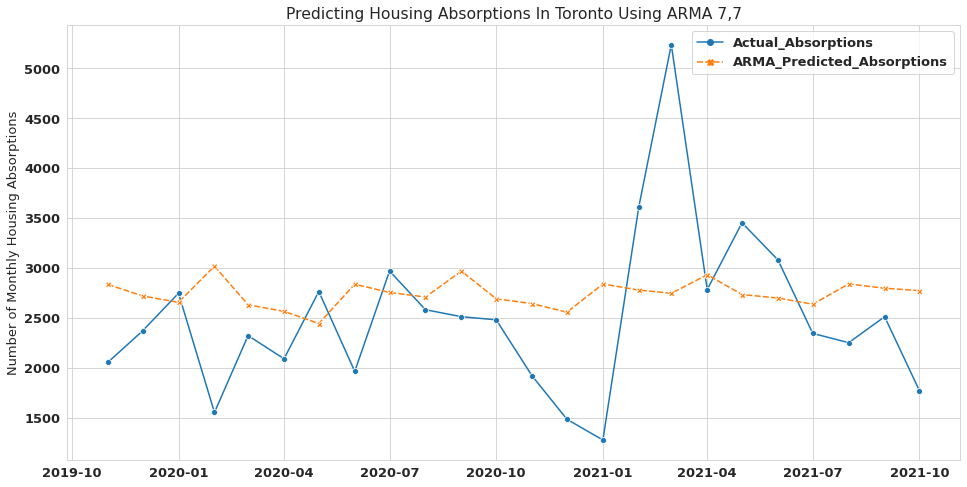

In [107]:
plot_results(ARMA_results,'ARMA 7,7')
print_evaluate(ARMA_results.Actual_Absorptions, ARMA_results.ARMA_Predicted_Absorptions)

Compared to the twelve-month moving average, the ARMA (7,7) model is fairly similar in performance. Visually, it is apparent that the predictions stay close to the mean but do have greater month over month fluctuations when compared to the twelve-month model. I would say that this model is better at matching the overall structure and changes in the data but caution that the statistically significant values at lag seven may have been a coincidence, and that the ACF and PACF were simply picking up noise in the data.

From what I have observed so far, I would recommend the use of either a twelve-month moving average or an ARMA (7,7) model for forecasting housing absorptions. If only one month is required to be forecasted, the twelve-month moving average is the more appropriate. If a larger forecasting window is required, then it is recommended to use the ARMA (7,7).

In the last part I will have a look at how the very popular Facebook Prophet model performs.

## Part 3 - The Facebook Prophet Approach

The reason for using Prophet is that it is a well known package in the Data Science community for being able to handle momentum shifts in the data, otherwise known as changepoints. I already observed in the STL plot that the absorption data has multiple changepoints, and that the trend fluctuates quite frequently over time, so this should be a good test for Prophet. For now I am going to leave the Prophet parameters as default to see how it holds up.

In [49]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [50]:
#Establish the train and test sets

fb_train = pd.DataFrame({'ds':trainset.index, 'y':trainset.values})
fb_test = pd.DataFrame({'Date':testset.index, 'Actual_Absorptions':testset.values}).set_index('Date')

In [51]:
#Fit prohpet to the trainset

prophet_model = Prophet()
prophet_model.fit(fb_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
#Make predictions for test observations
prophet_forecast = prophet_model.make_future_dataframe(periods=test_obs, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)
prophet_forecast = prophet_forecast[['ds','yhat']]

In [53]:
prophet_forecast.rename(columns={'ds':'Date',
                                 'yhat':'Prophet_Predicted_Absorptions'}, inplace = True)
prophet_forecast.set_index('Date', inplace=True)

In [54]:
#Combine the prophet forecast and acutal absorptions
prophet_combined = pd.merge(fb_test, prophet_forecast, on='Date', how='left')
prophet_combined

,Actual_Absorptions,Prophet_Predicted_Absorptions
Date,,
2019-11-01,"2,057.00","2,435.06"
2019-12-01,"2,372.00","2,756.40"
2020-01-01,"2,749.00","3,616.71"
2020-02-01,"1,556.00","2,493.38"
2020-03-01,"2,325.00","2,697.77"
2020-04-01,"2,093.00","2,654.60"
2020-05-01,"2,766.00","2,928.87"
2020-06-01,"1,967.00","2,235.41"
2020-07-01,"2,971.00","2,296.55"


Mean Absolute Error: 627.0
Root Mean Sqaured Error: 839.0
Mean Absolute Percent Error 27.0
__________________________________


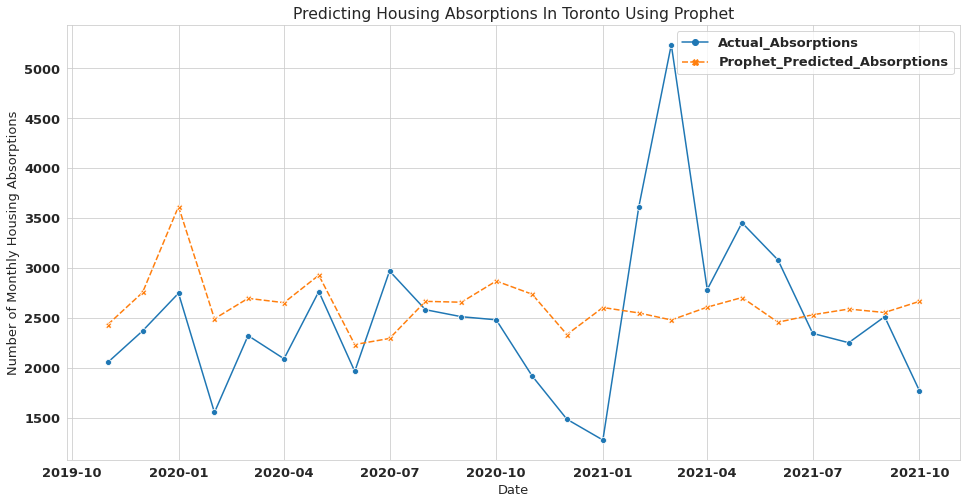

In [108]:
plot_results(prophet_combined,'Prophet')
print_evaluate(prophet_combined.Actual_Absorptions, prophet_combined.Prophet_Predicted_Absorptions)

The first few months of predictions using Prophet are rather impressive. While it does over predict what the actual absorptions are, it is the best model when it comes to matching the structure and fluctuations in the data. From my original business use case, I would say it is more advantageous to over predict absorptions than to under predict them. After a certain point the Prophet predictions look like they revert to the mean as well. I can see why this package has grown to immense popularity in the Data Science community given its accuracy and little amount of code.

From everything I have seen, I would opt for using Prophet as the method for forecasting a larger period outside of the data frame, but caution that the forecasting window should not be too large. To finish off, I'll produce a six-month forecast outside of the absorption data using Prophet, and include the upper and lower bounds of the predictions. The default Prophet uncertainty intervals is set at 80%.

## Conclusions

Housing absorptions is a noisy data set, with no clear trend or seasonality. The data seems to fluctuate randomly and there are multiple changepoints, which makes forecasting very challenging. None of the tested forecasting methods are perfect and should not be taken for granted. Depending on the business needs, and the number of periods that need to be forecasted, decision makers should select an appropriate forecasting method.

If a period of only one month is required to be forecasted, then it is recommended to use a simple twelve-month moving average given its simplicity and relative accuracy to a more complicated machine learning approach. If a larger period is required to be forecasted then it is recommended to keep the forecasting window as small as possible, and use either ARMA (7,7) or Prophet. However, it must be noted that the autoregressive (p) and moving average (q) components in the ARMA(7,7) model, while they are statistically significant, they may be picking up on noise in the data set which could lead to untrustworthy results.

## Forecasting Six Months Of Housing Absorptions Using Prophet

In [56]:
#Make a final dataframe that covers the entire data frame
final_df = pd.DataFrame({'ds':df_uni.index, 'y':df_uni.values})

In [136]:
prophet_model_final = Prophet()
prophet_model_final.fit(final_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [78]:
#Set the final forcast period to be six months

final_prophet_forecast = prophet_model_final.make_future_dataframe(periods=6, freq='MS')
final_prophet_forecast = prophet_model_final.predict(final_prophet_forecast).tail(6)
final_prophet_forecast = final_prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
final_prophet_forecast

,ds,yhat,yhat_lower,yhat_upper
247,2021-11-01,"2,542.19","1,472.28","3,674.67"
248,2021-12-01,"2,366.17","1,173.22","3,461.85"
249,2022-01-01,"2,786.03","1,571.25","3,940.16"
250,2022-02-01,"2,576.51","1,435.69","3,718.95"
251,2022-03-01,"2,379.00","1,193.48","3,565.72"
252,2022-04-01,"2,566.73","1,435.76","3,755.62"


In [137]:
#Establish the final plot by combining the entire data frame and the forecast

final_plot = final_df.append(final_prophet_forecast).tail(25) #Set to the final 25 points so the entire dataframe isn't plotted

final_plot.rename(columns={'ds':'Date',
                           'y':'Actual Absorptions',
                           'yhat':'Absorptions Forecast',
                           'yhat_upper':'Upper Bound Forecast',
                           'yhat_lower':'Lower Bound Forecast'
                           }, inplace = True)

final_plot.set_index('Date', inplace=True)

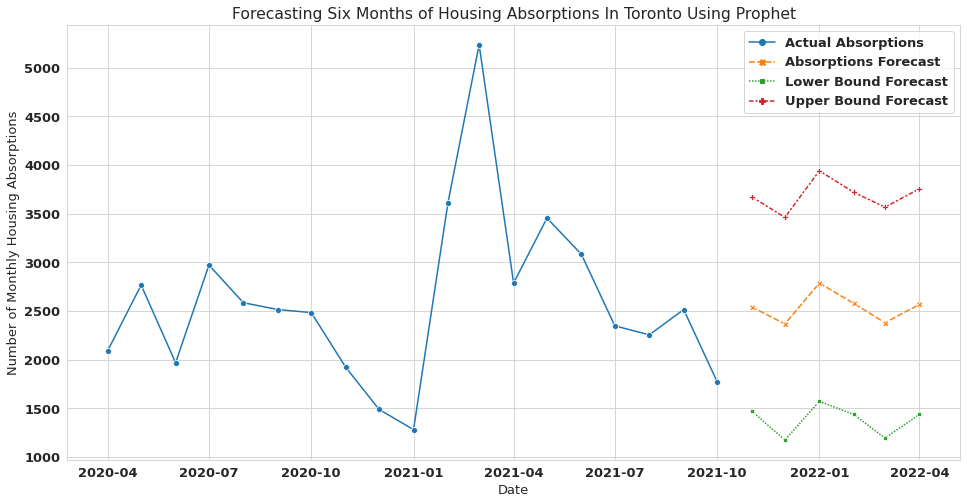

In [139]:
fig, ax = plt.subplots(figsize=[16,8])
ax = sns.lineplot(data=final_plot, markers = True)
ax.set_title('Forecasting Six Months of Housing Absorptions In Toronto Using Prophet')
ax.set_ylabel('Number of Monthly Housing Absorptions');

This is the end of the notebook. If you have come this far, thank you for taking the time to go through my work. I hope you have found it insightful.